# KKBox音乐用户数据分析及预测

![png](./pics/mind.png)

## 一.背景分析

KKBOX，是专业的音乐资讯服务软件。使用全球独步的创意与技术，获得多家国内与国际知名音乐出版发行公司热情的赞助合作，让聆听音乐的便利与智慧财产的保护，取得了完美的平衡。在台湾音乐占着重要的地位。主要服务于东南亚地区，包括：台湾、香港、新加坡、马来西亚等。

数据来源：Kaggle网站上的kkbox数据 https://www.kaggle.com/c/kkbox-music-recommendation-challenge/

主要包括三份数据：会员信息数据、歌曲信息数据和用户行为数据。以下是三份数据的具体内容：
#### members.csv
user information.

- msno
- city
- bd: age. Note: this column has outlier values, please use your judgement.
- gender
- registered_via: registration method
- registration_init_time: format %Y%m%d
- expiration_date: format %Y%m%d

#### songs.csv
The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language

#### train.csv
- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


## 二. 目标确定
由于这里是先有数据才进行分析，所以，确定目标时要结合现有的数据。

1.为产品和运营改进提供数据支持

通过对用户画像、用户行为、歌曲特征数据进行分析，找出提高用户粘性的方法。

2.对会员数据进行分类

使用维度分析法，构建数据立方体，具体按照以下三个维度：会员年限，（一个月内）重复歌曲数，听歌数量，对会员进行分类。

3.对用户听歌情况进行预测

预测指定用户（在一个月内）是否会重复听某首歌曲。


## 三. 数据合并及预处理

In [ ]:
import pandas as pd
import numpy as np
from time import time

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier    
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, recall_score, precision_score

### 3.1 数据加载及合并

In [82]:
# 加载并观察用户行为数据
df = pd.read_csv('train.csv')
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [86]:
df.target.value_counts()

1    3714656
0    3662762
Name: target, dtype: int64

In [15]:
print('数据集中包含{}个唯一用户。'.format(len(df.msno.unique())))

数据集中包含30755个唯一用户。


In [3]:
# 查看 msno, song_id 是否有空缺
def null_info(df):
    info = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})
    info=info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
    display(info)
null_info(df)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
null values (nb),0.0,0.0,18371.000000,414804.000000,21539.000000,0.0
null values (%),0.0,0.0,0.249017,5.622618,0.291959,0.0


In [90]:
# 加载并观察会员信息数据
members = pd.read_csv('members.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [89]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


In [91]:
# 加载并观察歌曲信息数据
songs = pd.read_csv('songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [92]:
# 数据合并
df_m = pd.merge(df, members, how='left', on='msno')
df_m_s = pd.merge(df_m, songs, how='left', on='song_id')
df_m_s.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0


In [21]:
print('合并后的数据包含{}个数据样本，{}个属性变量。'.format(df_m_s.shape[0],df_m_s.shape[1]))

合并后的数据包含7377418个数据样本，18个属性变量。


In [22]:
df_m_s.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')

### 3.2 重复值检测
对合并后的数据进行重复值检测，如果存在则进行删除

In [26]:
# 重复值检测
df_m_s.duplicated().sum()

0

In [31]:
df_m_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
expiration_date           int64
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
dtypes: float64(2), int64(6), object(10)
memory usage: 1.0+ GB


### 3.3 计算会员年限
这里以月份为单位

In [11]:
# 为了之后进行切片处理，先把格式转换成string类型，
df_m_s.registration_init_time = df_m_s.registration_init_time.apply(str)
df_m_s.expiration_date = df_m_s.expiration_date.apply(str)

In [12]:
# 获取会员注册和到期时间中的年和月
df_m_s.registration_year = df_m_s.registration_init_time.str.slice(0,4).astype(int)
df_m_s.registration_month = df_m_s.registration_init_time.str.slice(4,6).astype(int)

df_m_s.expiration_year = df_m_s.expiration_date.str.slice(0,4).astype(int)
df_m_s.expiration_month = df_m_s.expiration_date.str.slice(4,6).astype(int)

In [13]:
# 计算各用户的会员时长
df_m_s['duration(months)'] = (df_m_s.expiration_year - df_m_s.registration_year)*12 + (12 - df_m_s.registration_month) + df_m_s.expiration_month

In [14]:
# 保存合并后的数据
df_m_s.to_csv('member_songs.csv',index=False)

In [2]:
# 读取并查看数据
df_m_s = pd.read_csv('member_songs.csv')
df_m_s.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,duration(months)
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,81
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0,88
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,88
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,88
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,81


## 四. 数据探索及分析
接下来主要使用Tableau进行数据的探索、分析及可视化。

#### 异常值的处理（这部分处理通过Tableau进行）
比如：年龄，经检测有负数的年龄，也有一百多岁的年龄，在分析年龄时候，会把过小以及过大的年龄进行排除。

比如：会员期限，经检测有负数，在分析的过程中则排除有负数的这部分数据进行分析。


### 1. 用户画像分析

#### 1.1 性别
![png](./pics/m_gender.png)

** 分析 **

图中柱形的高度表示男性用户、女性用户以及未进行性别填写的用户数量。

橙色代表在一个月内会再次听歌的情形，也就是说粘性较高的用户；蓝色则代表一个月内不会再次听歌的情形，也就是说粘性较低的用户。百分比数字则表示每部分占总用户数的百分比。

通过此数据可知，男性用户略多于女性用户（约高出2%），但大部分用户不会填写自己的性别。由于不同性别的用户在一个月内是否会再次听歌的百分比非常相近，因此不同性别对用户粘性的影响不大。

#### 1.2 年龄
![png](./pics/m_age.png)

** 分析 **

图中横轴（bd）代表年龄，纵轴代表用户数，橙色代表粘性较高的用户，蓝线代表粘性较低用户。

通过观察可知，15～35岁的用户最多，因此在歌曲引进以及歌曲推送时以此年龄段为主。同时，不同年龄段，用户是否会重复听歌的趋势也基本相似，因此年龄对用户是否会再次收听某首歌的影响不大。

#### 1.3 城市
![png](./pics/m_city.png)

** 分析 **

图中柱形的高度表示不同城市的用户数量，这里的城市用数字来代表。

橙色代表在一个月内会再次听歌的情形，也就是说粘性较高的用户；蓝色则代表一个月内不会再次听歌的情形，也就是说粘性较低的用户。

从图中可知，城市编号为1，5，11的用户最多。同时，由于不同城市的用户在一个月内是否会再次听歌的百分比非常相近，因此不同性别对用户粘性的影响不大。

#### 1.4 注册方式
![png](./pics/m_registered_via.png)

** 分析 **

横轴为注册方法的编号，纵轴为人数。

通过编号为7、9、4、3注册的用户最多，可见这几种注册方式最受用户欢迎。而对于每一种注册方式而言用户在一个月内是否会再次听歌的百分比非常相近，因此不同注册方式对用户粘性的影响不大。

#### 1.5 会员期限
![png](./pics/m_duration.png)

** 分析 **

横轴为会员时长，单位为月份，纵轴为会员人数。

现存会员中1年（12个月）的会员最多，占总体的2.247%，也就是说大部分的会员为一年的会员，因此可以采取一些营销措施来促使办理了一年会员的用户再次进行会员购买，比如：办理第二年会员再加送一个月的会员。同时还要想办法获取新用户，以及提高会员的转换率。

### 2. 用户行为分析
#### 2.1 source_system_tab
system_tab被用来对KKBOX手机app功能进行分类，而source_system_tab则代表用户是通过哪一个功能来触发了此次听歌行为。

![png](./pics/source_system_tab01.png)

![png](./pics/source_system_tab02.png)

** 分析 **

橙色代表在一个月内会再次听歌的情形，也就是说粘性较高的用户；蓝色则代表一个月内不会再次听歌的情形，也就是说粘性较低的用户。

通过观察可看出，用户最常通过"my library", "discover", "search" 这三个功能进行听歌。同时当target为1（一个月内会再次听歌）时，从"my library"进入听歌的达到61.68%，超过半数，因此提高"my library"的点击率则很可能提高用户听歌的频率，提高用户粘性，比如：把"my library"功能键置于首页。

#### 2.2 source_screen_name
screen_name表示用户所看到的布局名称。

![png](./pics/source_screen_name01.png)

![png](./pics/source_screen_name02.png)

** 分析 **

“Local playlist more”, “Online playlist more”, "Radio"是被用户听得最多的三个列表。而其中“Local playlist more”和“Online playlist more”的重复听歌的比例也最高。因此为了提高用户听歌频率，可以把“Local playlist more”和“Online playlist more”放在用户比较容易找到的地方。

#### 2.3 source_type
source_type表示用户从移动app上第一次播放音乐的入口。

![png](./pics/source_type01.png)

![png](./pics/source_type02.png)

** 分析 **

用户首次播放音乐的入口最多的是"local-library"，同时"local-library"也是所有入口中占用户重复听歌比例最大的入口。因此可以通过提高用户对歌曲的下载率来提高用户听歌的频率，从而提高活跃度和粘性。

### 3. 歌曲特征分析


In [5]:
songs = pd.read_csv('songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


#### 3.1 song_length(歌曲长度)
![png](./pics/s_songLength01.png)
![png](./pics/s_songLength02.png)

** 分析 **

歌曲长度大部分集中在310589附近，存在少部分长度远大于均值的歌曲。

橙色（1）代表在一个月内会再次听歌的情形，也就是说粘性较高的用户；蓝色（0）则代表一个月内不会再次听歌的情形，也就是说粘性较低的用户。纵轴代表歌曲的平均长度，可见歌曲长度对用户是否会重复听歌影响不大。

#### 3.2 language（歌曲语言）
![png](./pics/s_language.png)

** 分析 **

歌曲语言编号为3的歌曲量最多，说明此种语言相比其他语言而言更受用户的欢迎。

通过观察不同类别语言的歌曲中，是否被重复听的比例（target为1或0）可见，歌曲语言对用户是否会重复听歌影响不大。

#### 3.3 artist_name（艺术家）

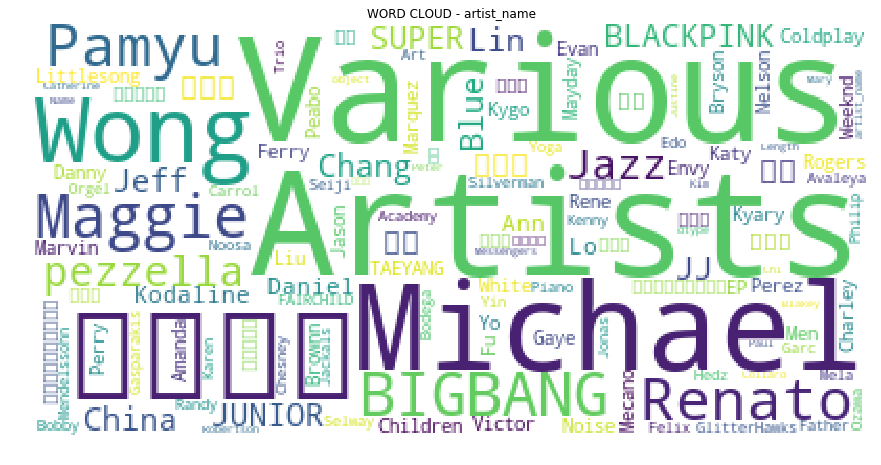

In [12]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=70, 
                          random_state=42
                         ).generate(str(songs['artist_name']))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - artist_name")
plt.axis('off')
plt.show()

** 分析 **

艺术家的名字中出现最多的是Various Artists，Michael，Bigbang，Renato。

#### 3.4 composer（作曲者）	

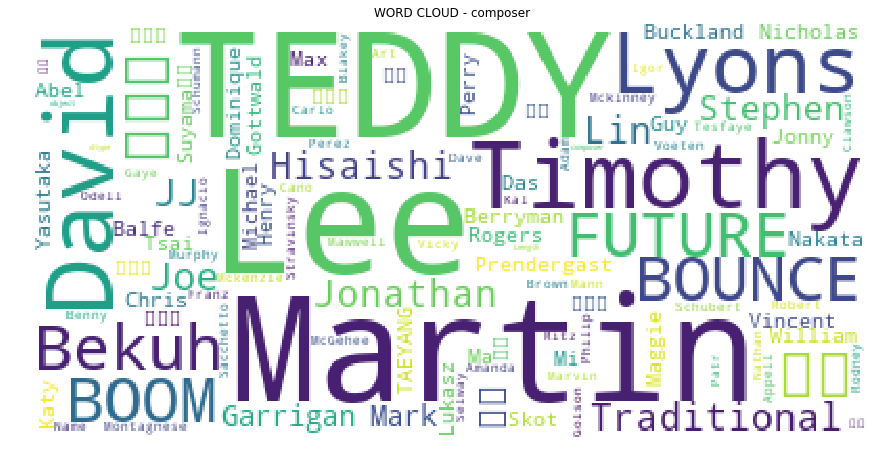

In [15]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

newStopWords= ['NaN']

stopwords.update(newStopWords)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=70, 
                          random_state=42
                         ).generate(str(songs['composer']))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - composer")
plt.axis('off')
plt.show()

** 分析 **

作曲者中出现最多的是：Teddy，Lee，Martin。

#### 3.5 lyricist（作词者）

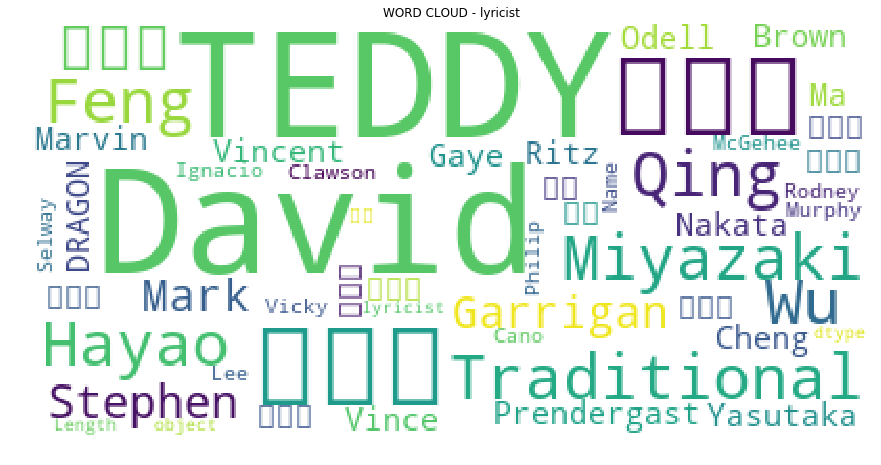

In [14]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

newStopWords= ['NaN']

stopwords.update(newStopWords)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=70, 
                          random_state=42
                         ).generate(str(songs['lyricist']))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - lyricist")
plt.axis('off')
plt.show()

** 分析 **

作词者中，出现最多的是Teddy，David。

## 二. 会员分类并标签化
### 1. 数据预处理

#### 1.1 属性筛选

In [ ]:
# 获取对分组有用的属性
member_group = df_m_s[['msno','target','duration(months)']]

#### 1.2 空缺值检测

In [91]:
member_group.isnull().sum()

msno                0
target              0
duration(months)    0
dtype: int64

#### 1.3 异常值检测及处理

1. 检测target，查看是否有非0或1的target
2. 检测duration(months)，查看小于0duration(months)，若其数量较少则直接进行删除

In [49]:
# 检测target
member_group.target.unique()

array([1, 0])

In [53]:
# 检测duration(months)
display(member_group[member_group['duration(months)']<0])

,msno,target,duration(months)
2487533,1Y+bNz3FxSoJnKOcR/Q8VJGXZbWIstrW0HfBe5LZzKA=,0,-520
2487534,1Y+bNz3FxSoJnKOcR/Q8VJGXZbWIstrW0HfBe5LZzKA=,0,-520
2487535,1Y+bNz3FxSoJnKOcR/Q8VJGXZbWIstrW0HfBe5LZzKA=,0,-520


In [92]:
# 筛选非异常数据
member_group = member_group[member_group['duration(months)']>0]

### 2. 会员分类

按照以下三个维度：会员年限，（一个月内）重复歌曲数，听歌数量，对会员进行分类

- 111 : "年限较长会员|歌曲重复次数多|听歌次数多"
- 110 : “年限较长会员|歌曲重复次数多”
- 101 : "年限较长会员|听歌次数多"
- 011 : "歌曲重复次数多|听歌次数多"
- 100 : "年限较长会员"
- 010 : "歌曲重复次数多"
- 001 : "听歌次数多"
- 000 : "需要进行挽留会员"

#### 2.1 计算

In [93]:
# 计算每个用户（一个月内）重复歌曲数，听歌数量，会员年限
member_group = member_group.groupby('msno').agg({'duration(months)': lambda x:x.mean(),
                                                 'target': lambda x:x.sum(),
                                                 'msno': lambda x:x.count()})

member_group.rename(columns={'target': 'recurrent_num', 
                             'msno': 'listend_num'}, inplace=True)
member_group.head()

,duration(months),recurrent_num,listend_num
msno,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,152,293,589
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,26,141,220
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,45,76,108
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,61,1,16
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,81,82,222


#### 2.2 分组 

In [98]:
# 进行分组
mean1 = member_group['duration(months)'].mean()
mean2 = member_group['recurrent_num'].mean()
mean3 = member_group['listend_num'].mean()

member_group['duration_class'] = member_group['duration(months)'].apply(lambda x:1 if x>mean1 else 0)
member_group['recurrent_class'] = member_group['recurrent_num'].apply(lambda x:1 if x>mean2 else 0)
member_group['listend_class'] = member_group['listend_num'].apply(lambda x:1 if x>mean3 else 0)

member_group.head()

,duration(months),recurrent_num,listend_num,duration_class,recurrent_class,listend_class
msno,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,152,293,589,1,1,1
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,26,141,220,0,1,0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,45,76,108,0,0,0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,61,1,16,1,0,0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,81,82,222,1,0,0


In [100]:
member_group['class'] = member_group['duration_class'].map(str) + member_group['recurrent_class'].map(str) + member_group['listend_class'].map(str)
member_group['class'].head()

msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=    111
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=    010
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=    000
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=    100
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=    100
Name: class, dtype: object

#### 2.3 标签化 

In [106]:
# 进行标签化处理
def tag(x):
    if x == '111':
        return "年限较长会员|歌曲重复次数多|听歌次数多"
    elif x == '110':
        return "年限较长会员|歌曲重复次数多"
    elif x == '101':
        return "年限较长会员|听歌次数多"
    elif x == '011':
        return "歌曲重复次数多|听歌次数多"
    elif x == '100':
        return "年限较长会员"
    elif x == '010':
        return "歌曲重复次数多"
    elif x == '001':
        return "听歌次数多"
    elif x == '000':
        return "需要进行挽留会员"

member_group['tags'] = member_group['class'].map(tag)
member_group['tags'].head()

msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=    年限较长会员|歌曲重复次数多|听歌次数多
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=                 歌曲重复次数多
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=                需要进行挽留会员
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=                  年限较长会员
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=                  年限较长会员
Name: tags, dtype: object

## 三. 预测用户听歌情况
预测用户听歌情况也就是预测指定用户是否会重复听某首歌曲。

通过前面的数据探索及分析，了解到用户在一个月内是否会重复听某一首歌，主要与用户行为数据有关，因此预测这部分采用用户行为数据进行。

In [2]:
df = pd.read_csv('train.csv', dtype={'msno' : 'category',
                                     'song_id' : 'category',
                                     'source_system_tab' : 'category',
                                     'source_screen_name' : 'category',
                                     'source_type' : 'category',
                                     'target' : int
                                                })
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


### 1. 数据预处理
#### 1.1 空缺值检测及处理

In [3]:
# 空缺值检测
def null_info(df):
    info = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})
    info=info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
    display(info)
null_info(df)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
null values (nb),0.0,0.0,18371.000000,414804.000000,21539.000000,0.0
null values (%),0.0,0.0,0.249017,5.622618,0.291959,0.0


In [4]:
# 由于空缺的比例较小，因此直接进行删除
df_c = df.dropna()

In [5]:
# 对结果进行检测
def null_info(df_c):
    info = pd.DataFrame(df_c.isnull().sum()).T.rename(index={0:'null values (nb)'})
    info=info.append(pd.DataFrame(df_c.isnull().sum()/df_c.shape[0]*100).T.rename(index={0:'null values (%)'}))
    display(info)
null_info(df_c)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
null values (nb),0.0,0.0,0.0,0.0,0.0,0.0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0


#### 1.2 拆分特征属性和标签属性
'target'是标签属性，'source_system_tab', 'source_screen_name','source_type'是特征属性。

In [23]:
label = df_c['target']
features = df_c[['source_system_tab', 'source_screen_name','source_type']]

#### 1.3 把非数字特征转换成数字特征
通常，学习算法都预期输入是数字，这就需要转换非数字特征（称为分类变量）。一种转换分类变量的常见方式是独热编码方法。独热编码会为每个非数字特征的每个可能类别创建一个_“虚拟”_变量。

这里使用 pandas.get_dummies() 对数据进行独热编码。为每个非数字特征的每个可能类别创建一个虚拟变量。

In [24]:
features_final = pd.get_dummies(features)

#### 1.4 把数据集拆分为训练集和测试集

In [43]:
# 随机打乱并拆分数据，20%为测试集

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_final[0:1000],
                                                    label[0:1000],
                                                    test_size = 0.2,
                                                    random_state = 0)

### 2. 模型构建
#### 2.1 评估指标选择

预测广告的点击量，通常可以帮助我们帮助我们了解广告更受哪类人群的喜欢，适合在哪个时间段投放等等。还可以帮助预测CTR，进而预测ROAS、ROI等。
预测出用户在一个月内会重复听的歌曲，能帮助我们了解用户的喜欢，进一步给用户推荐他们更喜欢的歌曲。

首先准确率是评估模型效果的一个有效指标， 同时我们还可以通过 F-β 分数考虑精确率和召回率。由于我们希望尽可能多的找出用户喜欢的歌曲，因此在这里召回率似乎更重要一些。

精确率：TP/(TP+FP)，真正例占所有预测为正例的比。关注是否找得准。

召回率：TP/(TP+FN)，真正例占所有真实为正例的比。关注是否找的全。

F-β = (1+β2)⋅precision⋅recall / [ (β2⋅precision)+recall ]，β值越小越倾向于精确率， 因此取beta = 1.5。

#### 2.2 模型比较及选择
根据经验，选择SVM，LR，和DT进行初始模型尝试。

分别比较他们在不同数量的样本中时间消耗以及准确度和fbeta_score。

In [80]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    
    results = {}
    
    # 计算训练样本时间
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
    
    # 计算预测所花的时间
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    end = time() # Get end time
    
    results['pred_time'] = end - start
    
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=1.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print('train time is: {}'.format(results['train_time']))
    print('predition time is: {}'.format(results['pred_time']))
    print('accuracy on testing set is: {}'.format(results['acc_test']))
    print('fbeta score on testinig set is: {}'.format(results['f_test']))
    print('------------------------------------------------------')

In [81]:
# nitialize the three models
clf_A = SVC(random_state=42)
clf_B = LogisticRegression(random_state=42)
clf_C = DecisionTreeClassifier(random_state=42)

# Calculate the number of samples for 50% and 100% of the training data
samples_100 = len(y_train)
samples_50 = int(samples_100 * 0.5)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_50, samples_100]):
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

SVC trained on 400 samples.
train time is: 0.0056610107421875
predition time is: 0.0015590190887451172
accuracy on testing set is: 0.835
fbeta score on testinig set is: 0.9426834563612679
------------------------------------------------------
SVC trained on 800 samples.
train time is: 0.015100240707397461
predition time is: 0.002825021743774414
accuracy on testing set is: 0.835
fbeta score on testinig set is: 0.9403050108932461
------------------------------------------------------
LogisticRegression trained on 400 samples.
train time is: 0.0015926361083984375
predition time is: 0.00027298927307128906
accuracy on testing set is: 0.845
fbeta score on testinig set is: 0.9339246119733924
------------------------------------------------------
LogisticRegression trained on 800 samples.
train time is: 0.0030829906463623047
predition time is: 0.00041294097900390625
accuracy on testing set is: 0.87
fbeta score on testinig set is: 0.9471346068414039
---------------------------------------------

通过比较上面三个模型对不同数量训练样本的训练、预测时间以及准确率和fbeta分数，可知决策树模型的训练和预测时间最少，同时在测试集上的准确度和fbeta分数最高,因此最终选择决策树模型。

#### 2.3 模型构建及优化
使用网格搜索交叉验证，为模型挑选最优参数。

In [79]:
clf = DecisionTreeClassifier(random_state=42)

parameters = { 'max_depth' :np.arange(15,20),'criterion':['gini', 'entropy']} 

scorer = make_scorer(fbeta_score, beta=1.5)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions  = (clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_test)

In [78]:
print("Final precision_score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall_score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))

Final precision_score on the testing data: 0.8907
Final recall_score on the testing data: 0.9760
Final accuracy score on the testing data: 0.8800
